In [1]:
# Primeiro carregue as imagens compactadas no notebook do collab
# Autorize o Collab a acessar seus arquivos no drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import keras

# Imports para redes neurais
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, MaxPooling2D
from keras.layers import Activation, Dense, Dropout, Flatten, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Imports para processamento de imagem
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
import imageio
import cv2

# Leitura do Dataset e Pré-processamento das Imagens

In [3]:
DIMENSION_SIZE=256
THRESHOLD = 40
MAX_IMAGES = 300

In [4]:
def thresholding(img, th):
    res = np.ones(img.shape).astype(np.uint8)
    res *= 255
    res[np.where(img < th)] = 0
    return res

In [5]:
imagePath = '/content/drive/Shareddrives/PDI/dataset/color/'
X = []
Y = []
names = []

i=0
for filename in os.listdir(imagePath):
    i = i + 1

    image = imageio.imread(imagePath+filename)
    # Alterando dimensao da imagem
    image = cv2.resize(image, dsize=(DIMENSION_SIZE, DIMENSION_SIZE), interpolation=cv2.INTER_CUBIC)
    image = np.array(img_to_array(image), dtype=float)

    # Conversao de espaço de cores para Lab
    # X contem canal L e Y os canais de cor a e b
    varX = rgb2lab(1.0/255*image)[:,:,0]
    varX = varX.reshape(1, DIMENSION_SIZE, DIMENSION_SIZE, 1)
    varY = rgb2lab(1.0/255*image)[:,:,1:]
    varY /= 128
    varY = varY.reshape(1, DIMENSION_SIZE, DIMENSION_SIZE, 2)

    X.append(varX)
    Y.append((varY, filename))

    # Usando 300 imagens inicialmente para evitar longos tempos de execução
    if i >= MAX_IMAGES:
        break



X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=1)
y_test, test_filenames = zip(*y_test)
y_train, test_filenames = zip(*y_train)

# Generating train data
X_filtered = []
for img in X_train:
    X_filtered.append(thresholding(img, THRESHOLD))
X_filtered = np.array(X_filtered).reshape(len(X_filtered), DIMENSION_SIZE, DIMENSION_SIZE, 1)
X_train = np.array(X_train).reshape(len(X_train), DIMENSION_SIZE, DIMENSION_SIZE, 1)
y_train = np.array(y_train).reshape(len(X_train), DIMENSION_SIZE, DIMENSION_SIZE, 2)

# Generating test data
X_test_filtered = []
for img in X_test:
    X_test_filtered.append(thresholding(img, THRESHOLD))
X_test_filtered = np.array(X_test_filtered).reshape(len(X_test_filtered), DIMENSION_SIZE, DIMENSION_SIZE, 1)
X_test = np.array(X_test).reshape(len(X_test), DIMENSION_SIZE, DIMENSION_SIZE, 1)
y_test = np.array(y_test).reshape(len(X_test), DIMENSION_SIZE, DIMENSION_SIZE, 2)

# Definição e treinamento do Modelo de Redes Neurais

In [6]:
# Definição do Modelo
filter_input = Input(shape=(DIMENSION_SIZE, DIMENSION_SIZE, 1,))
img_input = Input(shape=(DIMENSION_SIZE, DIMENSION_SIZE, 1,))

fusion_output = concatenate([img_input, filter_input], axis=3)
fusion_output = Conv2D(128, (1, 1), activation='relu', padding='same')(fusion_output)
fusion_output = Conv2D(128, (3, 3), activation='relu', padding='same')(fusion_output)
#output_img = Conv2D(128, (3, 3), activation='relu', padding='same')(img_input)
#fusion_output = concatenate([output_img, filter_input], axis=3)
#fusion_output = Conv2D(128, (1, 1), activation='relu', padding='same')(fusion_output)

output = MaxPooling2D((2, 2), padding='same')(fusion_output)
output = Conv2D(32, (3, 3), activation='relu', padding='same')(output)
output = Conv2D(32, (3, 3), activation='relu', padding='same')(output)
output = Conv2D(32, (3, 3), activation='relu', padding='same')(output)
output = MaxPooling2D((2, 2), padding='same')(output)
output = Conv2D(16, (3, 3), activation='relu', padding='same')(output)
output = Conv2D(16, (3, 3), activation='relu', padding='same')(output)
output = MaxPooling2D((2, 2), padding='same')(output)
output = Conv2D(8, (3, 3), activation='relu', padding='same')(output)
output = UpSampling2D((2, 2))(output)
output = Conv2D(32, (3, 3), activation='relu', padding='same')(output)
output = UpSampling2D((2, 2))(output)
output = Conv2D(32, (3, 3), activation='relu', padding='same')(output)
output = Conv2D(64, (3, 3), activation='relu', padding='same')(output)
output = UpSampling2D((2, 2))(output)
output = Conv2D(2, (3, 3), activation='tanh', padding='same')(output)

model = Model(inputs=[img_input, filter_input], outputs=output)
model.compile(optimizer='rmsprop',loss='huber_loss')

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 2)  0           input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 128 384         concatenate[0][0]            

In [8]:
# Treinamento do Modelo
model.fit([X_train, X_filtered], y_train, batch_size=10, epochs=50)

Epoch 1/50
27/27 [==============================] - 54s 245ms/step - loss: 0.0951
Epoch 2/50
27/27 [==============================] - 7s 244ms/step - loss: 0.0059
Epoch 3/50
27/27 [==============================] - 7s 246ms/step - loss: 0.0060
Epoch 4/50
27/27 [==============================] - 7s 245ms/step - loss: 0.0058
Epoch 5/50
27/27 [==============================] - 7s 246ms/step - loss: 0.0057
Epoch 6/50
27/27 [==============================] - 7s 248ms/step - loss: 0.0048
Epoch 7/50
27/27 [==============================] - 7s 248ms/step - loss: 0.0055
Epoch 8/50
27/27 [==============================] - 7s 249ms/step - loss: 0.0052
Epoch 9/50
27/27 [==============================] - 7s 251ms/step - loss: 0.0054
Epoch 10/50
27/27 [==============================] - 7s 250ms/step - loss: 0.0058
Epoch 11/50
27/27 [==============================] - 7s 252ms/step - loss: 0.0052
Epoch 12/50
27/27 [==============================] - 7s 253ms/step - loss: 0.0053
Epoch 13/50
27/27 [=====

In [9]:
save_model = 0
load_model = 0

## Diretorio para salvar ou carregar o model 
path_model = '/content/drive/Shareddrives/PDI/modelo'
if (save_model == 1):
  model.save(path_model)
if (load_model == 1):
  model = model.keras.models.load_model(path_model)

In [10]:
# Avaliação do modelo
model.evaluate([X_test, X_test_filtered], y_test, batch_size=1)

30/30 [==============================] - 1s 7ms/step - loss: 0.0051


0.005098096095025539

# Colorização das Imagens

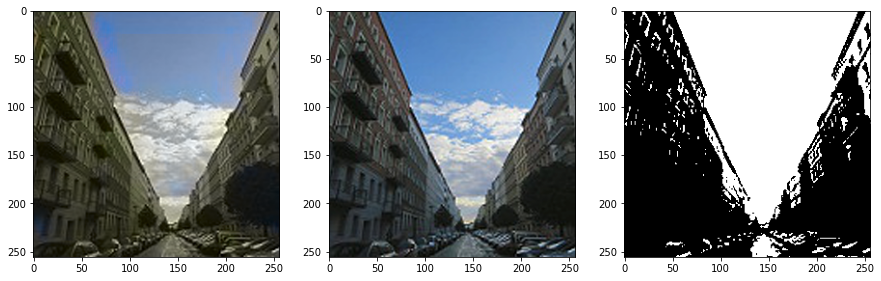

In [12]:
from matplotlib import pyplot as plt
# Gerando exemplos unitários de saída para observação
i = 24

image_for_test = X_test[i].reshape(1, DIMENSION_SIZE, DIMENSION_SIZE, 1)
filter_for_test = X_test_filtered[i].reshape(1, DIMENSION_SIZE, DIMENSION_SIZE, 1)
output = model.predict([image_for_test, filter_for_test])
output *= 128

coloredImage = np.zeros((DIMENSION_SIZE, DIMENSION_SIZE, 3))
coloredImage[:,:,0] = image_for_test[0][:,:,0]
coloredImage[:,:,1:] = output[0]
coloredImage = lab2rgb(coloredImage)
coloredImage *= 255
coloredImage = coloredImage.astype(np.uint8)

referenceImage = np.zeros((DIMENSION_SIZE, DIMENSION_SIZE, 3))
referenceImage[:,:,0] = X_test[i][:,:,0]
referenceImage[:,:,1:] = y_test[i]*128

referenceImage = lab2rgb(referenceImage)
referenceImage *= 255
referenceImage = referenceImage.astype(np.uint8)

plt.figure(figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(coloredImage)
plt.subplot(1,3,2)
plt.imshow(referenceImage)
plt.subplot(1,3,3)
plt.imshow(filter_for_test.reshape(DIMENSION_SIZE, DIMENSION_SIZE), cmap='gray')

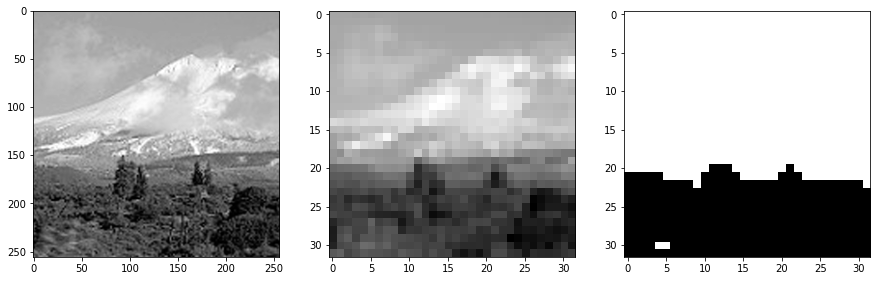

In [19]:
aux = image_for_test.reshape(DIMENSION_SIZE, DIMENSION_SIZE)
plt.figure(figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(aux, cmap='gray')

#
aux = cv2.resize(aux, dsize=(np.int32(DIMENSION_SIZE/8), np.int32(DIMENSION_SIZE/8)), interpolation=cv2.INTER_AREA)
plt.subplot(1,3,2)
plt.imshow(aux, cmap='gray')
plt.subplot(1,3,3)
filtered_aux = thresholding(aux, 40)
plt.imshow(filtered_aux, cmap='gray')